# Определение возраста покупателей

**Описание проекта.**

Сетевой супермаркет [«Хлеб-Соль»](http://xn--80abjcrmccwe6aeqms2j.xn--p1ai/) внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста. Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/).

Метрика качества: _MAE_ (mean_absolute_error).

**План выполнения проекта:**
- Провести исследовательский анализ набора данных в Jupyter (часть №1),
- Обучить модель в GPU-тренажёре и сохранить результат вывода модели на экран (часть №2).
- Объединить исслед. анализ данных, код и вывод модели. Проанализировать результат обучения модели (часть №3).

*разделение проекта на части обусловлено работой в разной среде (локальный компьютер / сервер с графическим ускорителем)

___

## Чтение данных

**Описание данных.**

Данные находятся в папке `/datasets/faces/`, а именно:
- одна папка со всеми изображениями `/final_files` и
- CSV-файл _labels.csv_ с двумя колонками: `file_name` и `real_age`.

Извлечь данные из папки поможет метод [ImageDataGenerator](https://keras.io/api/preprocessing/image/) — `flow_from_dataframe(dataframe, directory, ...)`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = 12345
CSV_PATH = '/datasets/faces/labels.csv'
IMG_PATH = '/datasets/faces/final_files/'

In [2]:
# чтение датасета
df = pd.read_csv(CSV_PATH)

In [3]:
# инициадизация загрузчика
datagen = ImageDataGenerator(rescale=1/255.)

# загрузка фотографий
train_datagen_flow = datagen.flow_from_dataframe(
    directory=IMG_PATH,
    dataframe=df,
    x_col='file_name',
    y_col='real_age',
    target_size=(200, 200),
    batch_size=32,
    class_mode='raw',
    seed=SEED)

features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


## Исследовательский анализ данных

- Посмотреть на размер выборки.
- Построить график распределения возраста в выборке.
- Напечатать на экране 10–15 фотографий для демонстрации устройства датасета.
- Сделать выводы о том, как результаты исследования повлияют на обучение модели.

In [4]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# тех. информация
print(df.info())
print('Кол-во дубликатов:', len(df[df['file_name'].duplicated()]))
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
Кол-во дубликатов: 0
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


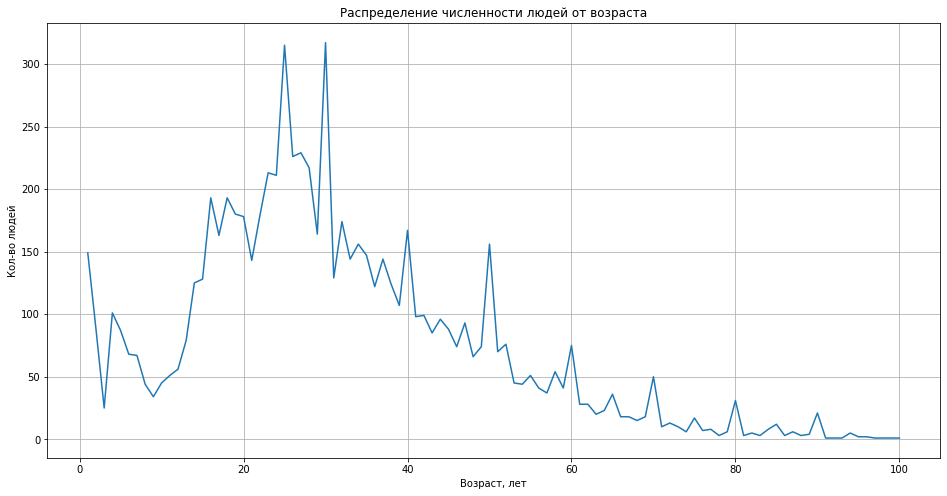

In [6]:
# распределение возраста (1ый вариант)
age_distribution = df['real_age'].value_counts().to_frame().reset_index().sort_values(by='index')
age_distribution.plot(x='index', y='real_age', grid=True, figsize=(16, 8), legend=False,
                      title='Распределение численности людей от возраста',
                      ylabel='Кол-во людей',
                      xlabel='Возраст, лет');

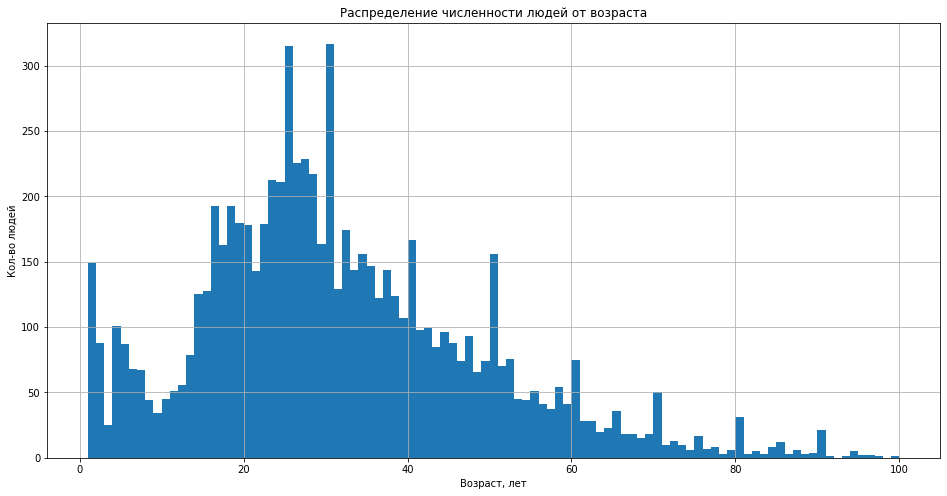

In [7]:
#UPD
# распределение возраста (2ой вариант)
df['real_age'].plot(kind='hist', bins=99, figsize=(16, 8), grid=True)
plt.title('Распределение численности людей от возраста')
plt.ylabel('Кол-во людей')
plt.xlabel('Возраст, лет');

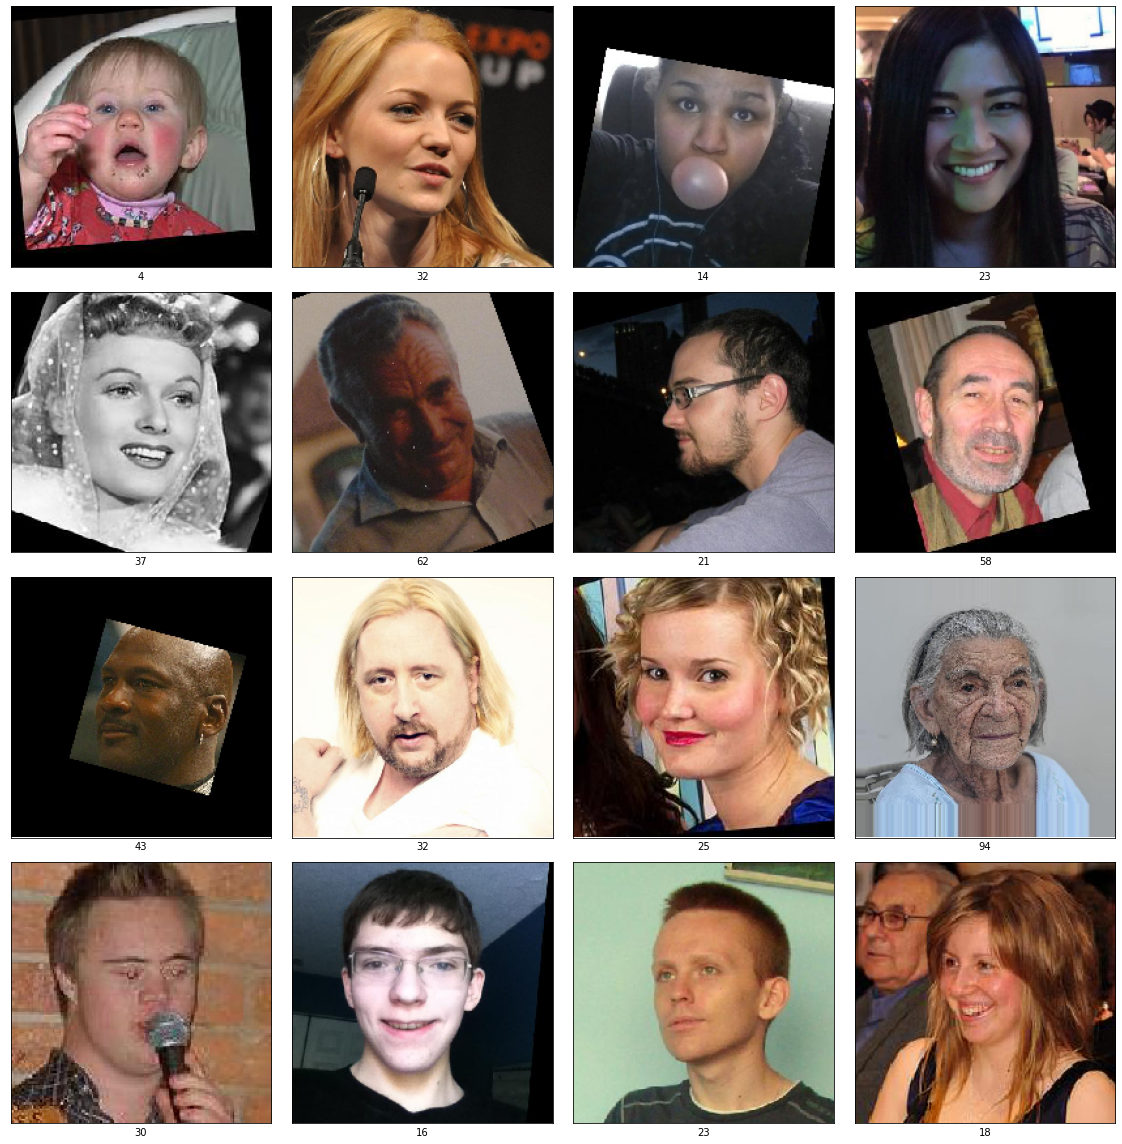

In [8]:
# вывод 16 изображений
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i+8])
    plt.xlabel(target[i+8])
    
    # для компактности оси оставяем пустыми и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:**

Датасет содержит более **7500 фотографий**. Пропуски, дубликаты - отсутствуют.

В наборе данных содержатся фото как цветные так и ч/б. Встрчаются различные ракурсы. Лицо может быть повёрнуто/наклонено под различным углом. Так же часть лица может быть не видна, закрыта очками или посторонними предметами. Либо лицо может находиться в тени или наоборот пересвечено. На заднем плане некоторых фотографий могут быть запечатлены и други люди. Возраст соответствует человеку на фотографии.

**Возрастные группы** распределены не равномерно. Наибольшее количество людей на фото в возрасте 15 - 30 лет, с ярко выраженными пиками 25 и 30 лет. Большое количество младенцев в возрасте 1 года и младше. Возможно это связано с округлением. Возраст детей младше 1 года округляли в большую сторону. Возрастная группа (0 лет) - отсутствует.

Учитывая поставленную задачу, из датасета можно **исключить фотографии детей** до 7 лет, поскольку они будут обязательно в сопровождении свои родителей. Оставить детей только школьного возраста и подростков, т.е. от 7 лет (включительно).

___

# Обучение модели

Построить и обучить **свёрточную нейронную** сеть на датасете с фотографиями людей. Добиться значения _MAE_ на тестовой выборке **не больше 8**.

Обязательный перечень функций:
- `load_train(path)`,
- `load_test(path)` - функцию загрузки тестовой выборки написать самостоятельно,
- `create_model(input_shape)`,
- `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)`.

В [статье](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) о датасете, с которым ведётся работа, значение _MAE_ равно 5.4 — если получиться _MAE_ меньше 7, это будет отличный результат!

_(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)_

```python
# импорт библиотек/объектов/классов собран в соотвутствующем разделе вначале проекта

# функция загрузки тренировочных данных
def load_train(path):
    # создание загрузчика данных
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255, vertical_flip=True) #UPD
    
    # загрузка данных (по частям/батчам)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow



# функция загрузки тестовых (валидационных) данных
def load_test(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return valid_datagen_flow



# функция создания нейронной сети
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential() # инициализация многослойной структуры
    model.add(backbone) # Средний слой - Костяк из внутренних повторяющихся блоков свёртки
    model.add(GlobalAveragePooling2D()) # Ending - Глобальный пуллинг (по всей фотографии)
    model.add(Dense(1, activation='relu')) # Ending - Полносвязный слой

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model



# функция обучения нейронной сети
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10

178/178 - 62s - loss: 189.3666 - mae: 10.2989 - val_loss: 564.9368 - val_mae: 18.7359
Epoch 2/10
178/178 - 39s - loss: 102.3292 - mae: 7.6809 - val_loss: 378.5658 - val_mae: 14.5689
Epoch 3/10
178/178 - 39s - loss: 66.1018 - mae: 6.2498 - val_loss: 436.2982 - val_mae: 15.7365
Epoch 4/10
178/178 - 40s - loss: 43.6133 - mae: 5.1182 - val_loss: 281.9627 - val_mae: 12.4836
Epoch 5/10
178/178 - 46s - loss: 28.6985 - mae: 4.1918 - val_loss: 106.9803 - val_mae: 7.7990
Epoch 6/10
178/178 - 45s - loss: 20.7930 - mae: 3.5030 - val_loss: 88.2499 - val_mae: 6.9965
Epoch 7/10
178/178 - 46s - loss: 16.2646 - mae: 3.1203 - val_loss: 82.4192 - val_mae: 7.0264
Epoch 8/10
178/178 - 40s - loss: 12.3176 - mae: 2.7306 - val_loss: 75.9955 - val_mae: 6.5690
Epoch 9/10
178/178 - 44s - loss: 10.6513 - mae: 2.4908 - val_loss: 77.8836 - val_mae: 6.6720
Epoch 10/10
178/178 - 45s - loss: 9.1306 - mae: 2.3031 - val_loss: 74.9938 - val_mae: 6.6299

60/60 - 11s - loss: 74.9938 - mae: 6.6299
Test MAE: 6.6299

```

## Анализ обученной модели

В проекте используется архитектура _RasNet50_ (с блоками из свёрточных слоёв), предобученая на изображениях и алгоритм обучения нейронной сети _Adam_. Эта комбинация позволяет существенно сократить время обучения: 7.5 минут (с использованием GPU). Значение метрики _MAE_ на тестовой выборке: 6.6299. Её значение можно грубо интерпретировать как погрешность предсказанного возраста ± 6.6299 лет.

Таким образом получается определить к какой возрастной группе можно отнести человека. Это пригодиться для **формирования рекомендаций** списка товаров, но не подойдёт для определения совершеннолетия  покупателя. Для этой задачи остро необходимо определять возраст. С текущей погрешностью будет огромное количество ложный срабатываний и ошибок. Возможно, для этой задачи потребуется отдельная модель занималась классификацией людей на две категории. Два специализированных инструмента чаще всего качественней чем один универсальный.

**Основное обучение** проходит в течение первых 5 эпох. Это заметно по функции ошибки и ключевой метрике - величины их изменения. Последующие эпохи (5-10) позволяют улучшить  результат предсказаний, но с каждой итерацией прирост качества становиться менее значительным. Можно остановить свой выбор на 5 эпохах обучения (это минимум), или задать бóльшее число эпох, если это позволяют ресурсы. Так же стоит учитывать, к каким факторам более склоняется заказчик к "скорости" или "качеству"?

Исходя из уточнений деталей при повторном обсуждении задачи, можно внести изменения в отдельные параметры уже готовой модели.

## Чек-лист

- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы